In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import sys

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj

from preprocess import *
from utils import *
from model import *
from train import *

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Dataset
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

seed = 8
torch.manual_seed(seed)

# Train test split
train_split = 0.8
batch_size = 16
visual_batch_size = 200
train_loader, val_loader, test_loader, visual_data_loader = prepare_data(dataset, train_split, batch_size, visual_batch_size)


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Class split - Training 0: 1901 1: 1568, Validation 0: 247 1: 187, Test 0: 253 1: 181


### CEM Clustering Functions

In [3]:
from collections import Counter

def cem_cluster_dict(activation_space_before, graph_nodes_enumerate):
    relevant_features = []
    for idx, real_node_number in enumerate(graph_nodes_enumerate):
        # Extract the features for the relevant nodes in the graph
        relevant_features.append(activation_space_before[idx, real_node_number, :])
    # Concatenate all the relevant features along the first dimension
    features = torch.cat(relevant_features, dim=0)
    
    # CEM-clustering
    _, indices = cem_clustering(features)
    

    # Use Counter to count occurrences
    occurrences = Counter(indices.tolist())

    # Sort the occurrences dictionary by values
    sorted_occurrences = sorted(occurrences.items(), key=lambda x: x[1], reverse=True)

    # Optionally, convert back to dictionary if needed
    sorted_occurrences_dict = dict(sorted_occurrences)
    print(len(indices))
    print(sorted_occurrences_dict)

    return sorted_occurrences_dict

In [4]:
def cem_plot(activation_space_before, graph_nodes_enumerate, DR_method, layer_num):
    relevant_features = []
    for idx, real_node_number in enumerate(graph_nodes_enumerate):
        # Extract the features for the relevant nodes in the graph
        relevant_features.append(activation_space_before[idx, real_node_number, :])
    # Concatenate all the relevant features along the first dimension
    features = torch.cat(relevant_features, dim=0)
    
    # CEM-clustering
    num_unique_rows, indices = cem_clustering(features)

    # Convert to numpy for dimensionality reduction
    features_np = features.detach().cpu().numpy()

    # Apply Dimension Reduction
    features_DR = dimension_reduction(features_np, DR_method)

    # ========================== Plotting Activation Space ==========================
    colors0 = plt.cm.jet(np.linspace(0, 1, num_unique_rows))

    for i, label in enumerate(indices):
        plt.scatter(features_DR[i, 0], features_DR[i, 1], color=colors0[int(label)], label=f'Cluster {int(label)}')

    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space before {layer_num} (CEM colored with {num_unique_rows} clusters)')
    plt.show()  

In [5]:
def cem_guidance(sorted_cluster_dict, threshold = 0.02):
    total_nodes = sum(sorted_cluster_dict.values())
    boundary = total_nodes * threshold
    selected_clusters = dict()
    for key, value in sorted_cluster_dict.items():
        if value > boundary:
            selected_clusters[key] = value
    
    return selected_clusters, len(selected_clusters)

## VanillaGNN for deciding the First DiffPool cluster number

Epoch 1, Train Loss: 0.6140, Val Loss: 0.5167, Val Acc: 0.6982
Epoch 2, Train Loss: 0.5645, Val Loss: 0.5211, Val Acc: 0.7281
Epoch 3, Train Loss: 0.5486, Val Loss: 0.4821, Val Acc: 0.7811
Epoch 4, Train Loss: 0.5309, Val Loss: 0.6379, Val Acc: 0.7811
Epoch 5, Train Loss: 0.5207, Val Loss: 0.4675, Val Acc: 0.8018
Epoch 6, Train Loss: 0.5212, Val Loss: 0.4861, Val Acc: 0.7488
Epoch 7, Train Loss: 0.5073, Val Loss: 0.4520, Val Acc: 0.8041
Epoch 8, Train Loss: 0.5090, Val Loss: 0.4758, Val Acc: 0.7926
Epoch 9, Train Loss: 0.5026, Val Loss: 0.4998, Val Acc: 0.7926
Epoch 10, Train Loss: 0.4966, Val Loss: 0.4948, Val Acc: 0.7811
Epoch 11, Train Loss: 0.4956, Val Loss: 0.4963, Val Acc: 0.7742
Epoch 12, Train Loss: 0.4977, Val Loss: 0.4995, Val Acc: 0.7535
Epoch 13, Train Loss: 0.4905, Val Loss: 0.4603, Val Acc: 0.8157
Epoch 14, Train Loss: 0.4894, Val Loss: 0.4582, Val Acc: 0.7972
Epoch 15, Train Loss: 0.4877, Val Loss: 0.4263, Val Acc: 0.8111
Epoch 16, Train Loss: 0.4816, Val Loss: 0.4505, V

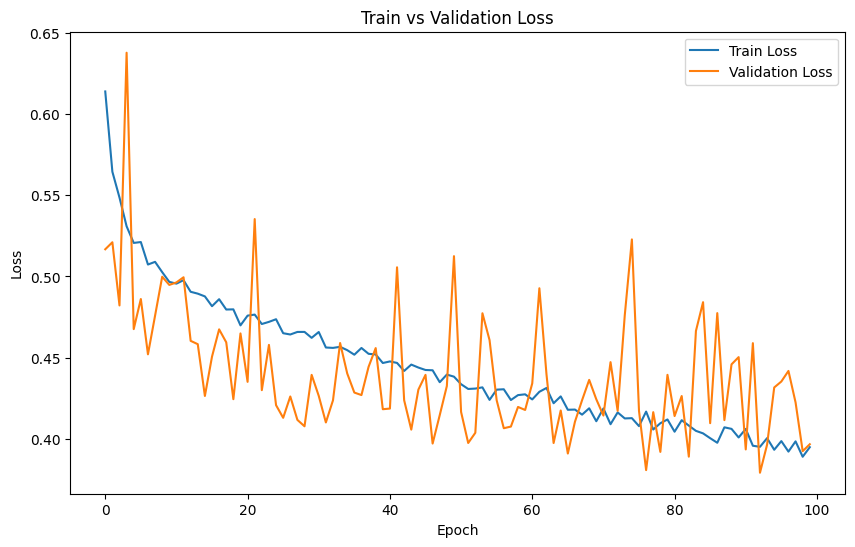

In [6]:
# Define the model
num_hidden_unit = 40
model_vanilla = VanillaGNN(dataset.num_features, num_hidden_unit, dataset.num_classes)
model_checkpoint_vanilla = f'vanilla_model_{num_hidden_unit}_seed_{seed}.pth'
model_type = 'vanilla'

# Training
lr = 0.001
epochs = 100
experiment_runner(model_vanilla, train_loader, val_loader, lr, epochs, model_checkpoint_vanilla, True, model_type)

In [7]:
num_hidden_unit = 40
model_vanilla0 = VanillaGNN(dataset.num_features, num_hidden_unit, dataset.num_classes)
model_vanilla0.load_state_dict(torch.load(f'vanilla_model_{num_hidden_unit}_seed_{seed}.pth'))
model_vanilla0.eval() 
model_type = 'vanilla'

criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = test(model_vanilla0, visual_data_loader, criterion, model_type)
print('Test Accuracy on Visual Data Loader:', test_acc)

Test Accuracy on Visual Data Loader: 0.8110599078341014


In [8]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)

    y_labels = data.y.tolist()
    
    graph_nodes = real_graph_node(data)
    
    out, x_gnn1_embed = model_vanilla0(batched_x, adj)
    
    break

In [9]:
graph_nodes_enumerate = [list(range(n)) for n in graph_nodes]
sorted_cluster_dict = cem_cluster_dict(x_gnn1_embed, graph_nodes_enumerate)

sorted_cluster_dict, n = cem_guidance(sorted_cluster_dict, threshold = 0.02)
print(sorted_cluster_dict)
print(n)

5656
{253: 433, 260: 300, 31: 285, 0: 255, 34: 204, 248: 199, 109: 166, 263: 165, 67: 125, 86: 105, 38: 103, 406: 95, 497: 91, 280: 77, 436: 68, 478: 66, 176: 66, 23: 66, 18: 66, 270: 65, 110: 62, 42: 50, 254: 50, 30: 49, 134: 46, 37: 42, 167: 42, 347: 41, 247: 40, 355: 39, 133: 39, 169: 39, 515: 34, 363: 34, 422: 34, 13: 33, 84: 33, 381: 33, 361: 32, 403: 31, 477: 30, 2: 25, 52: 24, 262: 24, 294: 23, 196: 22, 264: 22, 20: 21, 395: 20, 286: 20, 259: 19, 136: 19, 287: 19, 388: 18, 26: 18, 421: 18, 43: 18, 29: 16, 517: 16, 423: 16, 494: 16, 496: 16, 281: 15, 463: 15, 68: 15, 153: 15, 104: 14, 314: 14, 36: 14, 202: 13, 325: 13, 4: 13, 473: 13, 457: 13, 282: 12, 300: 12, 367: 12, 495: 12, 156: 12, 5: 12, 115: 11, 121: 11, 246: 11, 85: 11, 430: 11, 402: 11, 223: 11, 117: 11, 56: 10, 70: 10, 327: 10, 274: 10, 292: 10, 468: 10, 9: 10, 441: 10, 250: 9, 19: 9, 383: 9, 51: 9, 271: 8, 360: 8, 135: 8, 251: 8, 489: 8, 356: 8, 50: 8, 479: 8, 118: 8, 490: 7, 27: 7, 15: 7, 21: 7, 269: 7, 159: 7, 319: 

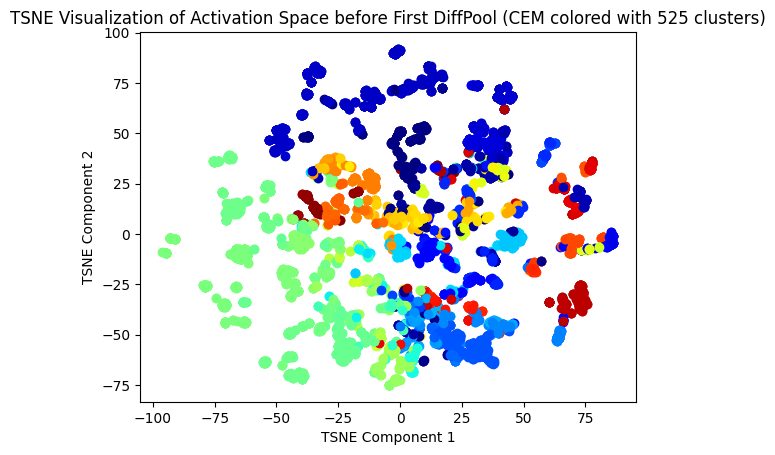

In [10]:
cem_plot(x_gnn1_embed, graph_nodes_enumerate, 'TSNE', 'First DiffPool')

## VanillaGNN2 for deciding the Second DiffPool cluster number

Epoch 1, Train Loss: 2.2126, Val Loss: 0.5798, Val Acc: 0.6959
Epoch 2, Train Loss: 1.9223, Val Loss: 0.5386, Val Acc: 0.7212
Epoch 3, Train Loss: 1.7473, Val Loss: 0.5365, Val Acc: 0.7396
Epoch 4, Train Loss: 1.5977, Val Loss: 0.5153, Val Acc: 0.7581
Epoch 5, Train Loss: 1.3916, Val Loss: 0.5229, Val Acc: 0.8065
Epoch 6, Train Loss: 1.2304, Val Loss: 0.4797, Val Acc: 0.7903
Epoch 7, Train Loss: 0.9257, Val Loss: 0.4591, Val Acc: 0.7926
Epoch 8, Train Loss: 0.8179, Val Loss: 0.5096, Val Acc: 0.7627
Epoch 9, Train Loss: 0.7550, Val Loss: 0.4680, Val Acc: 0.8065
Epoch 10, Train Loss: 0.7043, Val Loss: 0.4468, Val Acc: 0.8041
Epoch 11, Train Loss: 0.6680, Val Loss: 0.4501, Val Acc: 0.8018
Epoch 12, Train Loss: 0.6370, Val Loss: 0.4070, Val Acc: 0.8341
Epoch 13, Train Loss: 0.6114, Val Loss: 0.4339, Val Acc: 0.8226
Epoch 14, Train Loss: 0.5967, Val Loss: 0.4316, Val Acc: 0.8295
Epoch 15, Train Loss: 0.5714, Val Loss: 0.4150, Val Acc: 0.8249
Epoch 16, Train Loss: 0.5716, Val Loss: 0.4511, V

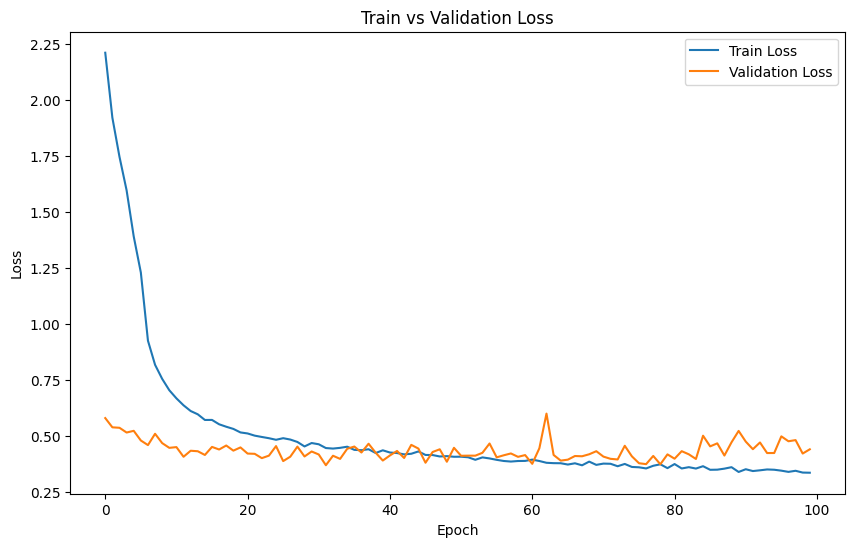

In [11]:
# Define the model
num_hidden_unit = 40
num_nodes1 = 8
model_vanilla2 = VanillaGNN2(dataset.num_features, num_hidden_unit, dataset.num_classes, num_nodes1)
model_checkpoint_vanilla2 = f'vanilla_model_hidden_unit_{num_hidden_unit}_diffpool_{num_nodes1}_seed_{seed}.pth'
model_type2 = 'vanilla2'

# Training
lr = 0.001
epochs = 100
experiment_runner(model_vanilla2, train_loader, val_loader, lr, epochs, model_checkpoint_vanilla2, True, model_type2)

In [12]:
num_hidden_unit = 40
num_nodes1 = 8
model_checkpoint_vanilla2 = f'vanilla_model_hidden_unit_{num_hidden_unit}_diffpool_{num_nodes1}_seed_{seed}.pth'
model_type2 = 'vanilla2'
model_vanilla2_0 = VanillaGNN2(dataset.num_features, num_hidden_unit, dataset.num_classes, num_nodes1)
model_vanilla2_0.load_state_dict(torch.load(model_checkpoint_vanilla2))
model_vanilla2_0.eval() 

criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = test(model_vanilla2_0, visual_data_loader, criterion, model_type2)
print('Test Accuracy on Visual Data Loader:', test_acc)

Test Accuracy on Visual Data Loader: 0.8202764976958525


In [13]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)

    y_labels = data.y.tolist()
    
    graph_nodes = real_graph_node(data)
    
    out, _, _, x_gnn2_embed, cluster_assignments1 = model_vanilla2_0(batched_x, adj)
    
    break

In [14]:
graph_nodes_enumerate_2 = []
for batch_idx in range(len(cluster_assignments1)):
    new_nodes = cluster_assignments1[batch_idx][:graph_nodes[batch_idx]]
    graph_nodes_enumerate_2.append(torch.unique(new_nodes).tolist())

sorted_cluster_dict_2 = cem_cluster_dict(x_gnn2_embed, graph_nodes_enumerate_2)

sorted_cluster_dict_2, n_2 = cem_guidance(sorted_cluster_dict_2, threshold = 0.02)
print(sorted_cluster_dict_2)
print(n_2)

767
{18: 57, 146: 34, 13: 13, 4: 10, 77: 9, 148: 8, 27: 8, 0: 8, 287: 8, 83: 8, 41: 7, 141: 7, 51: 7, 257: 6, 79: 6, 32: 6, 184: 5, 288: 5, 335: 5, 78: 5, 44: 5, 343: 5, 373: 5, 207: 4, 157: 4, 152: 4, 111: 4, 109: 4, 34: 4, 341: 4, 8: 4, 36: 4, 129: 4, 334: 4, 186: 4, 11: 4, 112: 4, 256: 3, 261: 3, 263: 3, 156: 3, 331: 3, 143: 3, 118: 3, 116: 3, 422: 3, 45: 3, 94: 3, 197: 3, 47: 3, 158: 2, 303: 2, 223: 2, 82: 2, 210: 2, 189: 2, 162: 2, 3: 2, 211: 2, 386: 2, 385: 2, 333: 2, 194: 2, 153: 2, 262: 2, 28: 2, 196: 2, 130: 2, 371: 2, 85: 2, 15: 2, 240: 2, 2: 2, 183: 2, 374: 2, 401: 2, 301: 2, 49: 2, 400: 2, 393: 2, 390: 2, 346: 2, 310: 2, 309: 2, 175: 2, 204: 2, 308: 2, 387: 2, 279: 2, 359: 2, 147: 2, 17: 2, 427: 2, 348: 2, 347: 2, 340: 2, 35: 2, 145: 2, 26: 2, 50: 2, 56: 2, 60: 2, 231: 2, 243: 1, 252: 1, 278: 1, 423: 1, 375: 1, 23: 1, 215: 1, 265: 1, 237: 1, 266: 1, 225: 1, 360: 1, 52: 1, 53: 1, 413: 1, 412: 1, 383: 1, 418: 1, 424: 1, 222: 1, 208: 1, 155: 1, 307: 1, 114: 1, 306: 1, 105: 1, 

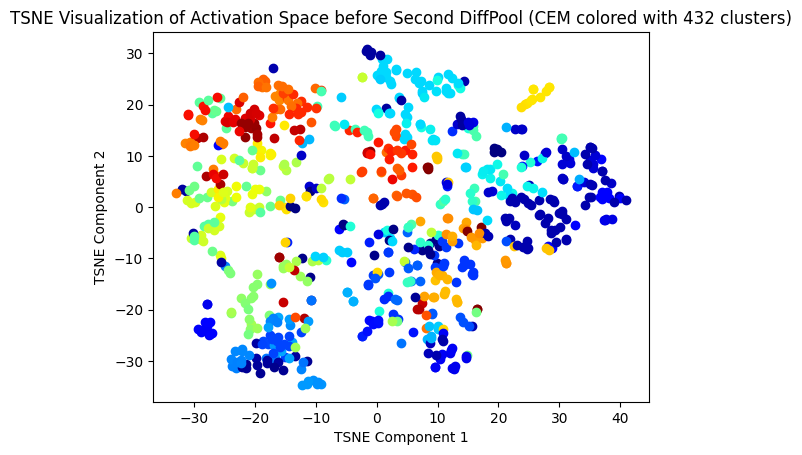

In [15]:
cem_plot(x_gnn2_embed, graph_nodes_enumerate_2, 'TSNE', 'Second DiffPool')